# 1.Importings

In [1]:
import os
import numpy as np
import pydicom
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
from tqdm import tqdm  # İşlem sürecini takip etmek için

In [2]:
root_dir_for_pickles = "pkl(s)"

df = pd.read_pickle(os.path.join(root_dir_for_pickles,"df_dcm_metadata"))
df.head(1)

,BitsAllocated,BitsStored,Columns,HighBit,PhotometricInterpretation,PixelData,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,...,Rows,SOPClassUID,SamplesPerPixel,SliceThickness,WindowCenter,WindowWidth,file_path,stroke_type,file_name,PixelPaddingValue
0,16,16,512,15,MONOCHROME2,Not Null,1,"[0.565, 0.565]",0.0,1.0,...,512,1.2.840.10008.5.1.4.1.1.2,1,3.0,40.0,120.0,data/Kanama Veri Seti\DICOM\10002.dcm,Kanama Veri Seti,10002.dcm,NaN


# 2. Prepocessing

In [16]:
# Önceden tanımladığın process_dicom fonksiyonun aslında `process_dicom` olarak çağrılmış, düzeltiyorum.
def process_dicom(file_path):
    # DICOM dosyasını oku
    ds = pydicom.dcmread(file_path)

    # Modality LUT uygula
    img = apply_modality_lut(ds.pixel_array, ds)

    # VOI LUT uygula
    img = apply_voi_lut(img, ds)
    
    img_resized = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)

    return img_resized

def save_image(image, output_folder, file_name):
    """
    Görüntüyü `.png` formatında belirtilen klasöre kaydeder.
    Klasör yoksa oluşturur.
    """
    # Klasör yoksa oluştur
    os.makedirs(output_folder, exist_ok=True)

    # Dosya yolu oluştur
    output_path = os.path.join(output_folder, file_name + '.png')

    # Kaydet
    plt.imsave(output_path, image, cmap='gray')

def process_dataframe(df, destination):
    """
    DataFrame içindeki dosyaları işleyerek belirtilen destination klasörüne kaydeder.
    """
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing DICOM Files"):
        # dosya yolu ve dosya ismini DataFrame'den al
        file_path = row['file_path']
        file_name = os.path.splitext(os.path.basename(file_path))[0]

        # Klasör ismini DataFrame'den al (örneğin: stroke_type kolonundan)
        stroke_type = row['stroke_type']

        # Hedef klasör yolunu oluştur (örneğin: destination/stroke_type/)
        output_folder = os.path.join(destination, stroke_type)

        # DICOM dosyasını işle
        processed_image = process_dicom(file_path)

        # Görüntüyü kaydet
        save_image(processed_image, output_folder, file_name)


In [4]:
# Ana klasör yolu
root_dir = "unprocessed"

# Veri çerçevesi için liste
data = []

# Alt klasörleri tarayarak veri çerçevesini oluştur
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)

    # Eğer bir klasörse işle
    if os.path.isdir(subdir_path):
        # Sadece 'pngs' klasörüne bak
        pngs_dir = os.path.join(subdir_path, "pngs")
        if os.path.isdir(pngs_dir):  # Eğer 'pngs' klasörü varsa
            for file in os.listdir(pngs_dir):
                if file.endswith(".png"):
                    file_path = os.path.join(pngs_dir, file)
                    label = 0 if "yok" in subdir.lower() else 1
                    data.append([file_path, label])

# DataFrame oluştur
df = pd.DataFrame(data, columns=["file_path", "label"])

# CSV olarak kaydet
csv_filename = "ct_image_labels_unprocessed.csv"
df.to_csv(csv_filename, index=False)


In [43]:
def process_brain_ct(image_path, output_size=(512, 512), skull_thresh=250, clean_min_size=1000, brain_thresh=10, brain_morph_kernel=(7, 7)):
    """
    Beyin CT görüntüsünde ROI belirleme, kafatasını çıkartma ve beyin maskesini oluşturma işlemlerini kapsayan ana fonksiyon.
    
    :param image_path: Görüntünün dosya yolu
    :param output_size: ROI'nin yeniden boyutlandırılacağı boyut
    :param skull_thresh: Kafatası için beyazlık eşiği
    :param clean_min_size: Küçük maskelerin temizlenmesi için minimum alan eşiği
    :param brain_thresh: Beyin dokusunu belirlemek için eşik değeri
    :param brain_morph_kernel: Morfolojik işlemler için çekirdek boyutu
    :return: İşlenmiş tüm görüntüler (ROI, kafatası maskesi, temizlenmiş maske, kafatası çıkarılmış görüntü, beyin maskesi, beyin segmentasyonu)
    """

    def extract_roi(image_path, output_size):
        """Verilen görüntüden ROI çıkarır."""
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError("Görüntü dosyası bulunamadı veya açılamadı.")

        blurred = cv2.GaussianBlur(image, (3, 3), 0)
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            raise ValueError("Kontur bulunamadı! ROI belirlenemedi.")

        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        roi = image[y:y+h, x:x+w]

        '''
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
        roi_masked = cv2.bitwise_and(image, image, mask=mask)[y:y+h, x:x+w]
        '''
        return cv2.resize(roi, output_size)

    def filter_skull(image, white_thresh):
        """Kafatasını maske olarak alıp çıkartır."""
        skull_mask = (image > white_thresh).astype(np.uint8) * 255
        kernel = np.ones((5,5), np.uint8)
        neighbor_mask = cv2.morphologyEx(skull_mask, cv2.MORPH_CLOSE, kernel)
        neighbor_mask = cv2.morphologyEx(neighbor_mask, cv2.MORPH_OPEN, kernel)
        skull_removed = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(neighbor_mask))
        return skull_removed, skull_mask

    def clean_masks(image, mask, min_size):
        """Küçük maskeleri temizleyerek düzgün bir görüntü elde eder."""
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        filtered_mask = np.zeros_like(mask, dtype=np.uint8)

        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_size:
                filtered_mask[labels == i] = 255  

        cleaned_image = np.where(filtered_mask == 255, 0, image)
        return cleaned_image, filtered_mask


    def extract_brain_mask(image, threshold=40, morph_kernel=(2, 2), min_size=15000):
        """
        Beyin maskesini oluşturur, ince bağlantıları koparır ve sadece en büyük gri alanı beyin olarak alır.
        
        :param image: Gri tonlamalı beyin CT görüntüsü
        :param threshold: Beyin dokusunu belirlemek için eşik değeri
        :param morph_kernel: Morfolojik işlemler için çekirdek boyutu
        :param min_size: Minimum kabul edilebilir beyin alanı
        :return: Beyin bölgesinin maskesi ve beyin segmentasyonu
        """
        # 1️⃣ Beyin maskesini oluştur (thresholding)
        _, brain_mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    
        # 2️⃣ Morfolojik işlemler ile temizleme
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel)
        brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
        brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_OPEN, kernel)
    
        # 3️⃣ Bağlantılı bileşenleri bul
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(brain_mask, connectivity=8)
    
        if num_labels < 2:
            return np.zeros_like(brain_mask), np.zeros_like(image)  # Hiçbir alan yoksa boş döndür
    
        # 4️⃣ İlk büyük alanı bul (arka plan hariç)
        max_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # En büyük bileşenin etiketi
    
        # 5️⃣ Sadece en büyük bileşeni tut
        filtered_mask = np.zeros_like(brain_mask, dtype=np.uint8)
        filtered_mask[labels == max_label] = 255
    
        # 6️⃣ Dar Bağlantıları Koparma (İskeletleme ve Morfolojik Erozyon)
        kernel_thin = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 8))  # Küçük kernel
        filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_ERODE, kernel_thin, iterations=2)  # İnce hatları kopar
        filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_OPEN, kernel_thin)  # Küçük parçaları temizle
    
        # 7️⃣ Koparma işleminden sonra tekrar en büyük bileşeni bul!
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(filtered_mask, connectivity=8)
        if num_labels > 1:
            max_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # En büyük bileşeni tekrar bul
            final_mask = np.zeros_like(filtered_mask, dtype=np.uint8)
            final_mask[labels == max_label] = 255  # Sadece en büyük bileşeni al
        else:
            final_mask = filtered_mask  # Eğer başka bileşen yoksa olduğu gibi bırak
    
        # 8️⃣ Beyin segmentasyonunu uygula
        brain_extracted = cv2.bitwise_and(image, image, mask=final_mask)
    
        return final_mask, brain_extracted



    # İşlemleri sırayla uygula
    roi_image = extract_roi(image_path, output_size)
    skull_removed, skull_mask = filter_skull(roi_image, skull_thresh)
    cleaned_image, cleaned_mask = clean_masks(roi_image, skull_mask, clean_min_size)
    
    # 📌 Güncellenmiş beyin maskesi fonksiyonunu kullan!
    brain_mask, brain_segmented = extract_brain_mask(cleaned_image, brain_thresh, brain_morph_kernel)

    return roi_image, skull_mask, cleaned_mask, cleaned_image, brain_mask, brain_segmented


In [44]:
def visualize_brain_processing(roi_image, skull_mask, cleaned_mask, cleaned_image, brain_mask, brain_segmented):
    """
    Beyin CT işlem sonuçlarını görselleştiren fonksiyon.

    :param roi_image: ROI belirlenmiş orijinal görüntü
    :param skull_mask: Kafatası maskesi
    :param cleaned_mask: Küçük alanlardan temizlenmiş maske
    :param cleaned_image: Kafatası çıkarılmış ve temizlenmiş görüntü
    :param brain_mask: Beyin maskesi
    :param brain_segmented: Beyin maskesi uygulanmış görüntü
    """
    plt.figure(figsize=(42, 6))

    images = [roi_image, skull_mask, cleaned_mask, cleaned_image, brain_mask, brain_segmented]
    titles = [
        "Orijinal Resim", "Orijinal Kafatası Maskesi", "Temizlenmiş Maske (Küçük Alanlar Silindi)",
        "Kafatası Çıkartılmış ve Küçük Alanlar Geri Döndürülmüş Görüntü", "Beyin Maskesi", "Beyin Maskesi Uygulanmış Görüntü"
    ]

    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis("off")

    plt.show()

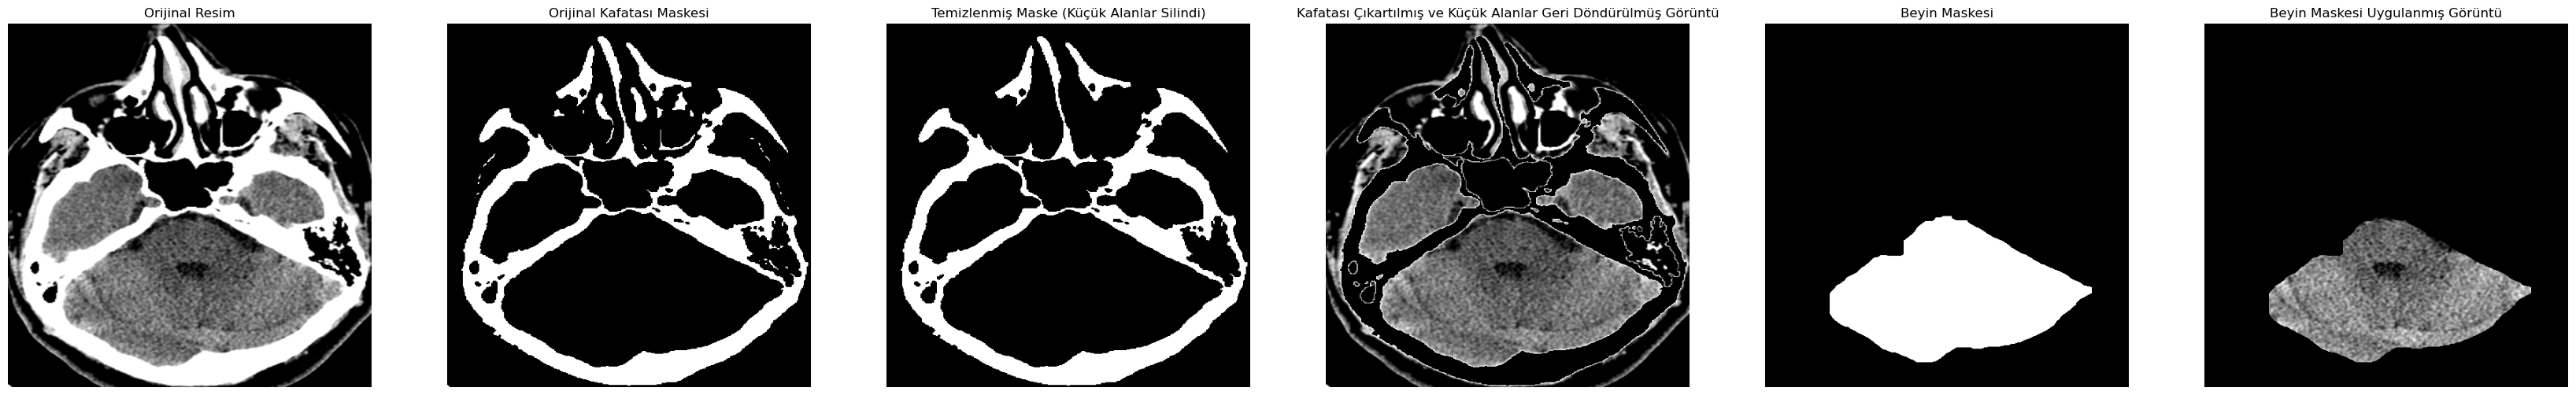

In [68]:
# Kullanım
image_path = "unprocessed/inme_yok/10104.png"

# Tüm işleme adımlarını içeren fonksiyon
roi_image, skull_mask, cleaned_mask, cleaned_image, brain_mask, brain_segmented = process_brain_ct(image_path)

# Görselleştirme fonksiyonunu çağır
visualize_brain_processing(roi_image, skull_mask, cleaned_mask, cleaned_image, brain_mask, brain_segmented)

In [55]:
def create_stroke_dataset(root_dir="unprocessed"):
    """
    Verilen ana klasördeki tüm alt klasörlerdeki görüntü dosyalarını tarayarak
    bir pandas DataFrame oluşturur.

    :param root_dir: Ana klasör yolu (varsayılan: "unprocessed")
    :return: file_path, stroke_type, file_name sütunlarına sahip pandas DataFrame
    """
    data = []

    # Ana klasördeki tüm alt klasörleri dolaş
    for stroke_type in os.listdir(root_dir):
        stroke_path = os.path.join(root_dir, stroke_type)

        # Eğer bir klasörse, içindeki dosyaları işle
        if os.path.isdir(stroke_path):
            for file_name in os.listdir(stroke_path):
                file_path = os.path.join(stroke_path, file_name)

                # Sadece görüntü dosyalarını ekleyelim (jpg, png, jpeg uzantıları)
                if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    data.append([file_path, stroke_type, file_name])

    # DataFrame oluştur
    df = pd.DataFrame(data, columns=["file_path", "stroke_type", "file_name"])

    return df

In [53]:
def process_and_save_images(df, output_folder_path):
    """
    Verilen DataFrame'deki her görüntü için process_brain_ct fonksiyonunu çalıştırır 
    ve hem segmentasyonu hem de beyin maskesini belirtilen klasöre kaydeder.

    :param df: file_path, stroke_type, file_name sütunlarını içeren DataFrame
    :param output_folder_path: İşlenmiş görüntülerin kaydedileceği ana klasör yolu
    """
    os.makedirs(output_folder_path, exist_ok=True)  # Kök çıktı klasörünü oluştur

    # tqdm ile ilerleme çubuğu ekleyerek DataFrame üzerinde iterasyon yap
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images", unit="image"):
        file_path = row["file_path"]  # Görüntünün tam yolu
        stroke_type = row["stroke_type"]  # İlgili inme türü (örneğin "iskemi", "kanama", "inme_yok")
        file_name = row["file_name"]  # Dosya adı

        # Görüntüyü işle
        try:
            _, _, _, _, brain_mask, brain_segmented = process_brain_ct(file_path)

            # PNG ve MASK klasörlerinin yolunu belirle
            stroke_folder = os.path.join(output_folder_path, stroke_type)
            png_folder = os.path.join(stroke_folder, "pngs")
            mask_folder = os.path.join(stroke_folder, "masks")

            # Klasörleri oluştur (varsa oluşturmaz)
            os.makedirs(png_folder, exist_ok=True)
            os.makedirs(mask_folder, exist_ok=True)

            # İşlenmiş dosya adlarını belirle (dosya adında değişiklik yapmadan)
            png_save_path = os.path.join(png_folder, file_name)
            mask_save_path = os.path.join(mask_folder, file_name)

            # İşlenmiş görüntüleri kaydet
            cv2.imwrite(png_save_path, brain_segmented)
            cv2.imwrite(mask_save_path, brain_mask)
        
        except Exception as e:
            print(f"❌ {file_name} işlenirken hata oluştu: {e}")


In [51]:
# Kullanım:
#stroke_df = create_stroke_dataset("unprocessed")
#stroke_df.to_csv("unprocessed_images")
stroke_df = pd.read_csv("csv(s)/unprocessed_images")

In [52]:
stroke_df.head(5)

,Unnamed: 0,file_path,stroke_type,file_name
0,0,unprocessed\inme_yok\10000.png,inme_yok,10000.png
1,1,unprocessed\inme_yok\10001.png,inme_yok,10001.png
2,2,unprocessed\inme_yok\10004.png,inme_yok,10004.png
3,3,unprocessed\inme_yok\10005.png,inme_yok,10005.png
4,4,unprocessed\inme_yok\10006.png,inme_yok,10006.png


In [58]:
process_and_save_images(stroke_df, "final_preprocessed/")

Processing Images: 100%|████████████████████████████████████████████████████████| 6650/6650 [03:13<00:00, 34.39image/s]
